# Harmonising Landsat and sentinel

* **Products used:** 


### Background 

### Description


***

## Getting started


### Load packages
Load key Python packages and any supporting functions for the analysis.

In [1]:
import datacube
import datacube.utils.rio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import pandas as pd
import xarray as xr
import geopandas as gpd
from odc.io.cgroups import get_cpu_quota
from datacube.utils.geometry import assign_crs
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import map_shapefile
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.classification import collect_training_data

#This will speed up loading data
datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)

/env/lib/python3.8/site-packages/datacube/storage/masking.py:7: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  warnings.warn("datacube.storage.masking has moved to datacube.utils.masking",


### Analysis parameters


In [7]:
path = 'data/harmonization_training.geojson' 
field = 'Class'
# Set up the inputs for the ODC query
time = ('2020')
measurements =  ['red','nir']
resolution = (-30,30)
output_crs='epsg:6933'

sample_size=10

In [8]:
ncpus=round(get_cpu_quota())
print('ncpus = '+str(ncpus))

ncpus = 4


## View the selected location
The next cell will display the selected area on an interactive map.
The red border represents the area of interest of the study.
Zoom in and out to get a better understanding of the area of interest.
Clicking anywhere on the map will reveal the latitude and longitude coordinates of the clicked point.

In [9]:
# Load input data shapefile
input_data = gpd.read_file(path).sample(sample_size).reset_index(drop=True)

input_data.head()

,Class,geometry
0,0,POINT (7.34507 26.97587)
1,0,POINT (35.09348 -1.34984)
2,0,POINT (-8.74645 11.05521)
3,0,POINT (46.88370 -23.15120)
4,1,POINT (49.00085 -13.12007)


In [10]:
query = {
    'time':time,
    'measurements': measurements,
    'resolution': resolution,
    'output_crs': output_crs
}

In [11]:
def feature_layers(query):
    #connect to the datacube
    dc = datacube.Datacube(app='feature_layers')
    
    ds_ls = load_ard(dc=dc,
                  products=['ls8_sr'],
                  min_gooddata=0.99,
                  verbose=False,
                  **query,
                 )
    
    ds_ls=calculate_indices(ds_ls, 'NDVI', collection='c2', drop=False)
    # load cloud-masked fractional cover using load_ard
    ds_s2 = load_ard(dc=dc,
                  products=['s2_l2a'],
                  like=ds_ls.geobox,
                  time=time,
                  measurements=['red','nir_2'], #use nir narrow to match with LS8
                  min_gooddata=0.99,
                  verbose=False
                 )

    #rename nir2 to trick calculate_indices
    ds_s2 = ds_s2.rename({'nir_2':'nir'})
    ds_s2 = calculate_indices(ds_s2, 'NDVI', collection='s2', drop=False)
    
    #match s2 at LS times with 2D tolerance
    ds_s2 = ds_s2.reindex(time=ds_ls.time, method='nearest', tolerance='2D')
    #grab the timestep with Landsat maximum NDVI, this will ensure we don't get a NaN
    t = ds_s2.NDVI.idxmax("time")
    ds_s2 = ds_s2.sel(time=t)
    ds_ls = ds_ls.sel(time=t)
    #rename bands to include sensor
    for band in ds_ls.data_vars:
        ds_ls = ds_ls.rename({band: band + '_ls8'})
        
    #rename bands to include sensor
    for band in ds_s2.data_vars:
        ds_s2 = ds_s2.rename({band: band + '_s2'})
        
    #merge results into single dataset 
    result = xr.merge([ds_ls, ds_s2],compat='override')
    result = assign_crs(result, crs='epsg:6933')
    return result

In [12]:
column_names, model_input = collect_training_data(
                                    gdf=input_data,
                                    dc_query=query,
                                    ncpus=ncpus,
                                    field=field,
                                    feature_func=feature_layers,
                                    )

  0%|          | 0/10 [00:00<?, ?it/s]

CPLReleaseMutex: Error = 1 (Operation not permitted)
CPLReleaseMutex: Error = 1 (Operation not permitted)


Percentage of possible fails after run 1 = 0.0 %
Removed 0 rows wth NaNs &/or Infs
Output shape:  (10, 7)


In [15]:
print(np.array_str(model_input, precision=2, suppress_small=True))

[[   0.      0.03    0.31    0.83  348.   2371.      0.74]
 [   0.      0.04    0.34    0.8   387.   3171.      0.78]
 [   0.      0.07    0.32    0.64  853.   3455.      0.6 ]
 [   0.      0.04    0.32    0.76  443.   3217.      0.76]
 [   0.      0.36    0.44    0.1  3506.   5154.      0.19]
 [   1.      0.07    0.22    0.52  555.   1817.      0.53]
 [   0.      0.05    0.34    0.73  506.   3305.      0.73]
 [   0.      0.01    0.12    0.81  627.   2674.      0.62]
 [   1.      0.07    0.34    0.65  592.   3463.      0.71]
 [   1.      0.06    0.37    0.71  554.   3109.      0.7 ]]


In [16]:
df = pd.DataFrame(data=model_input, columns=column_names)
df.head()

,Class,red_ls8,nir_ls8,NDVI_ls8,red_s2,nir_s2,NDVI_s2
0,0.0,0.028938,0.314883,0.831671,348.0,2371.0,0.744024
1,0.0,0.038178,0.338643,0.797370,387.0,3171.0,0.782462
2,0.0,0.071507,0.324315,0.638689,853.0,3455.0,0.603993
3,0.0,0.044392,0.320685,0.756805,443.0,3217.0,0.757924
4,0.0,0.357645,0.437395,0.100309,3506.0,5154.0,0.190300
5,1.0,0.070820,0.222785,0.517583,555.0,1817.0,0.532040
6,0.0,0.053440,0.340540,0.728717,506.0,3305.0,0.734453
7,0.0,0.012355,0.115123,0.806162,627.0,2674.0,0.620115
8,1.0,0.071755,0.341778,0.652966,592.0,3463.0,0.708015
9,1.0,0.063092,0.372935,0.710603,554.0,3109.0,0.697516


In [19]:
df['NDVI_ls8'].values.shape

(10,)

### 1:1 plots

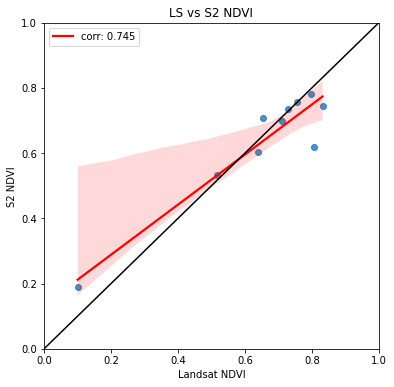

In [23]:
x=df['NDVI_ls8'].values
y=df['NDVI_s2'].values

r = stats.spearmanr(x, y)

fig, ax = plt.subplots(1,1, sharey=True, figsize=(6,6))

sns.regplot(x=x, y=y, ax=ax,
              line_kws={'label':"corr: "+str(round(r[0],3)), 'color':'red'})
ax.legend()
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
ax.plot([0, 1], [0, 1], 'k-')
ax.set_xlabel('Landsat NDVI')
ax.set_ylabel('S2 NDVI')
ax.set_title('LS vs S2 NDVI');